In [1]:
# https://github.com/sagieppel/Train-Semantic-Segmentation-Net-with-Pytorch-In-50-Lines-Of-Code/blob/main/Train.py

In [2]:
import os
import numpy as np
import cv2
import torch
import torchvision.transforms as tf
from course_ocr_t1.data import MidvPackage
from pathlib import Path
from torch.nn import functional as F

Learning_Rate=1e-5
width, height=256, 128 # image width and height
batchSize=16

data_path = Path("/home/artem/PycharmProjects/course_ocr/course_ocr/task1/midv500_compressed")
data_packs = MidvPackage.read_midv500_dataset(data_path)

test_split = []
train_split = []

for dp in data_packs:
    for i in range(len(dp)):
        if dp[i].is_test_split():
            test_split.append(dp[i])
        else:
            train_split.append(dp[i])
                    

In [3]:
print(train_split[0].image)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=450x800 at 0x7FB648718290>


In [4]:
import segmentation_models_pytorch

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

#----------------------------------------------Transform image-------------------------------------------------------------------
transformImg=tf.Compose([tf.Resize((height,width)),tf.ToTensor(),tf.Normalize(
    (0.485, 0.456, 0.406), 
    (0.229, 0.224, 0.225))])

#---------------------Read image ---------------------------------------------------------

def ReadRandomImage(listImages):  # First lets load random image and  the corresponding annotation
    idx = np.random.randint(0,len(listImages)) # Select random image
    Img = listImages[idx].image

    width, height = Img.size[0], Img.size[1]
    
    # make make of id card
    polygon = [(x, y) for x, y in listImages[idx].gt_data['quad']]
    mask = Image.new('L', (width, height), 0)
    ImageDraw.Draw(mask).polygon(polygon, outline=0, fill=1)
    mask = np.array(mask)
    
    # transform to tensor, rescale, ... image and mask
    Img = transformImg(Img)
    _, h, w = Img.shape
    mask = cv2.resize(mask, (w, h))

    AnnMap = torch.Tensor([mask])
    return Img, AnnMap


#--------------Load batch of images-----------------------------------------------------
def LoadBatch( listImages ): # Load batch of images
    images = torch.zeros([batchSize,3,height,width])
    ann = torch.zeros([batchSize, height, width])
    for i in range(batchSize):
        images[i],ann[i]=ReadRandomImage( listImages )
    return images, ann

#--------------Load and set net and optimizer-------------------------------------
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Net = segmentation_models_pytorch.UnetPlusPlus(in_channels=3, classes=1)
Net=Net.to(device)
optimizer=torch.optim.Adam(params=Net.parameters(),lr=Learning_Rate) # Create adam optimizer

mode = 'binary'
loss_f = segmentation_models_pytorch.losses.LovaszLoss(mode)



/home/artem/anaconda3/envs/CenterNetRefs/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811756765/work/torch/csrc/utils/tensor_new.cpp:201.)


Saving Model0.torch
0 ) Loss= 1.7207764


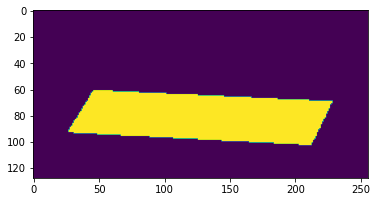

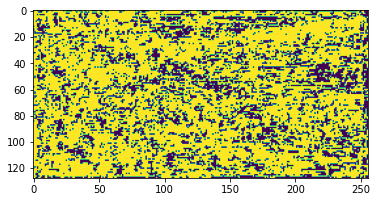

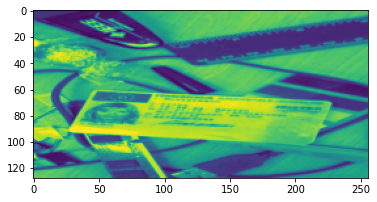

100 ) Loss= 1.0487695


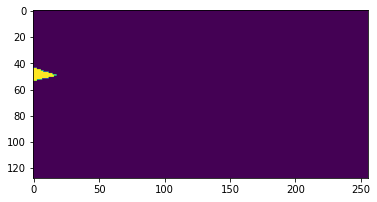

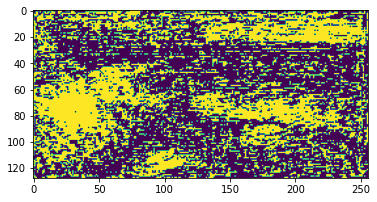

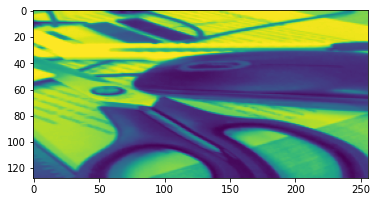

200 ) Loss= 0.67329586


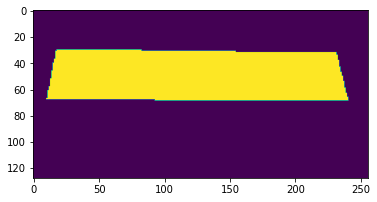

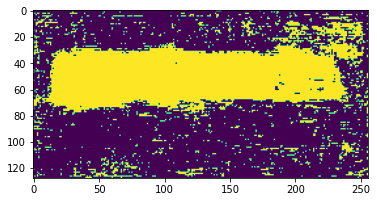

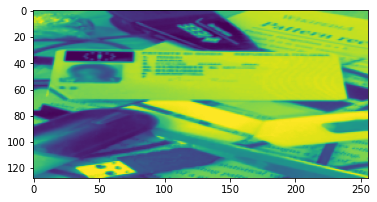

300 ) Loss= 0.508198


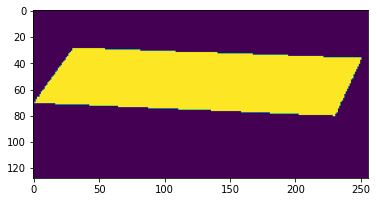

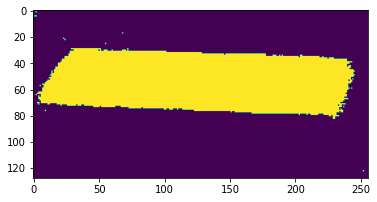

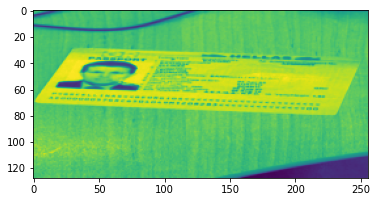

400 ) Loss= 0.33262852


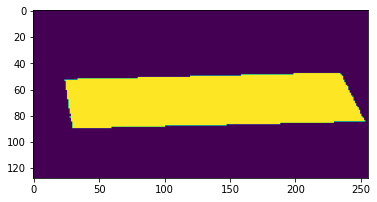

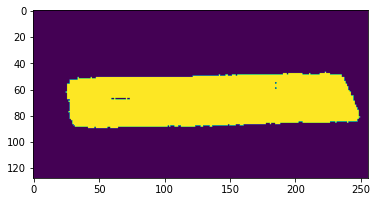

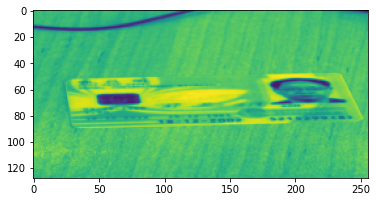

500 ) Loss= 0.23423727


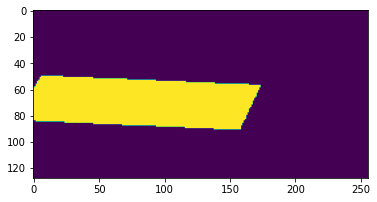

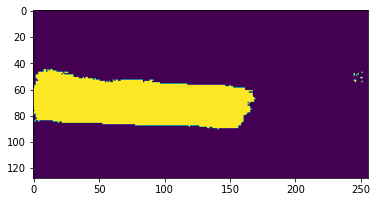

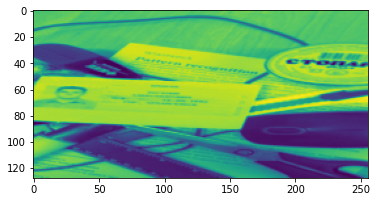

600 ) Loss= 0.14189264


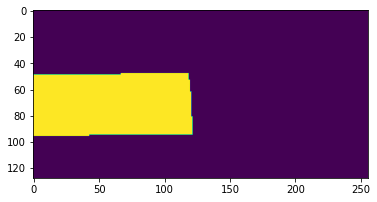

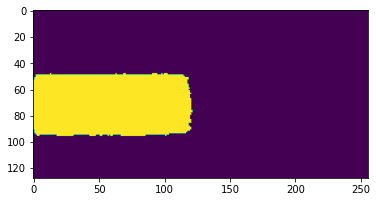

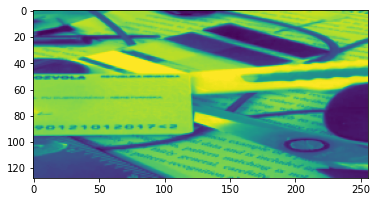

700 ) Loss= 0.12303701


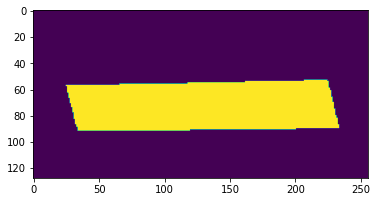

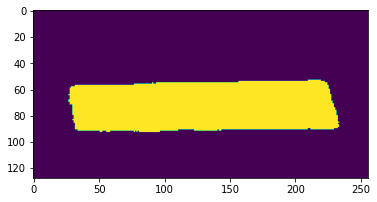

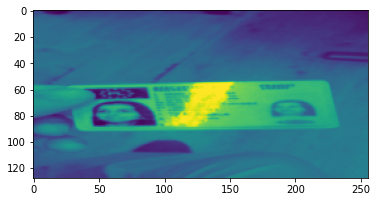

800 ) Loss= 0.13544866


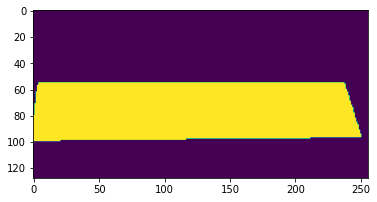

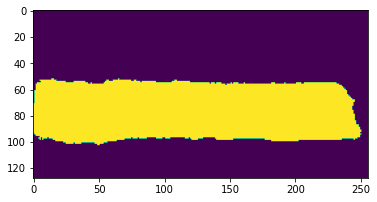

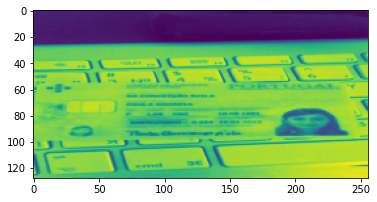

900 ) Loss= 0.09460596


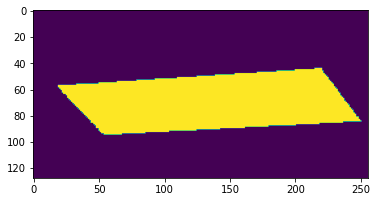

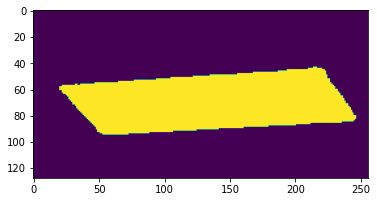

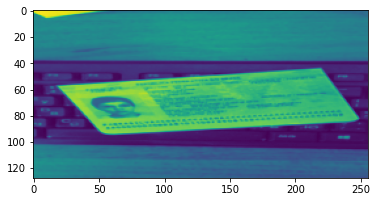

Saving Model1000.torch
1000 ) Loss= 0.07731515


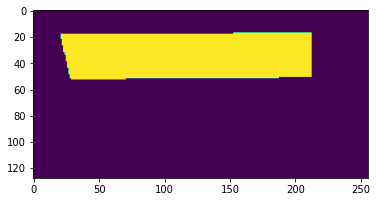

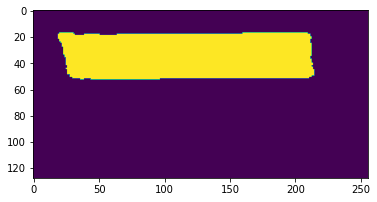

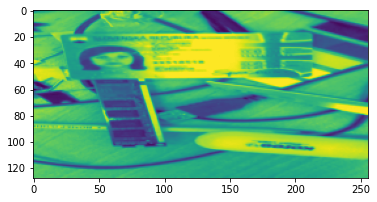

1100 ) Loss= 0.059796505


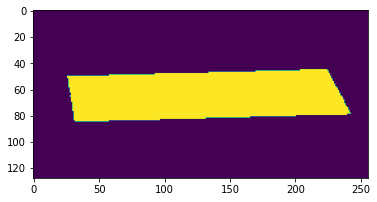

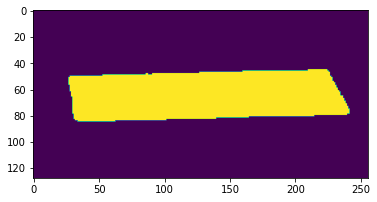

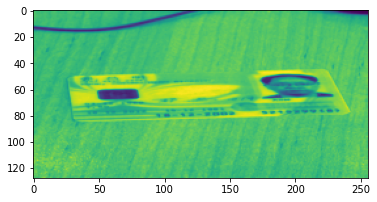

1200 ) Loss= 0.0549048


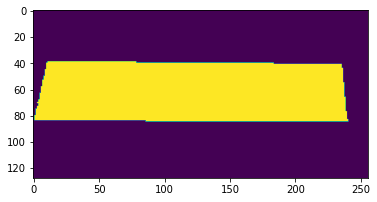

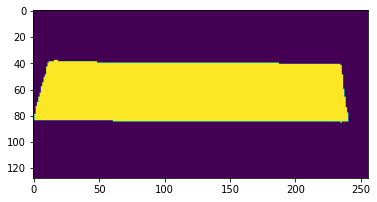

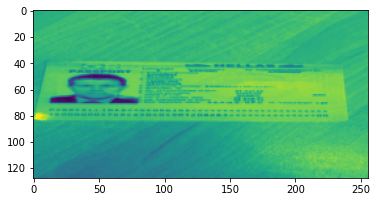

1300 ) Loss= 0.042902824


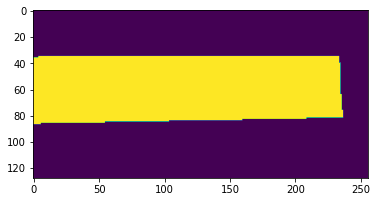

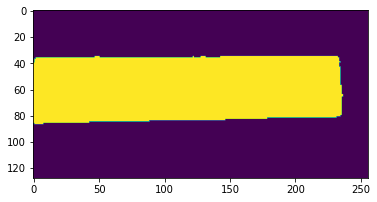

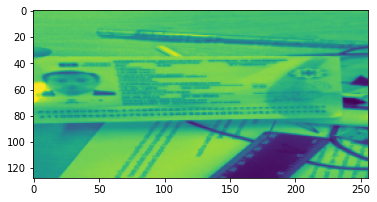

1400 ) Loss= 0.049004324


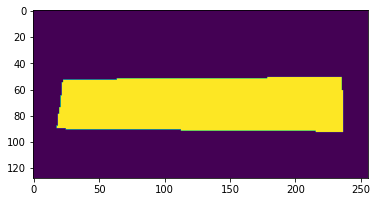

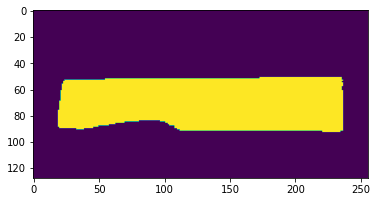

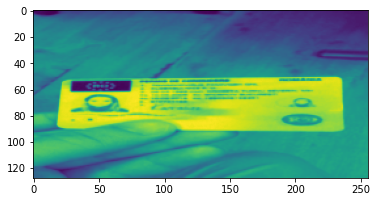

1500 ) Loss= 0.05166032


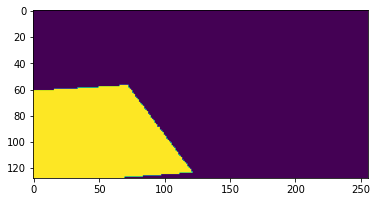

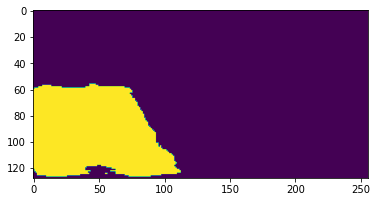

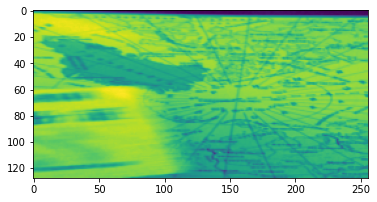

1600 ) Loss= 0.04737577


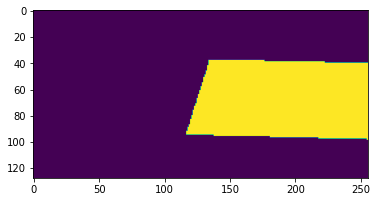

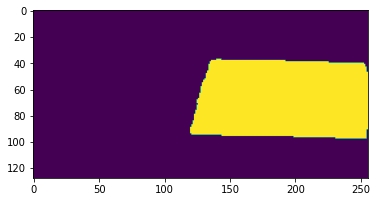

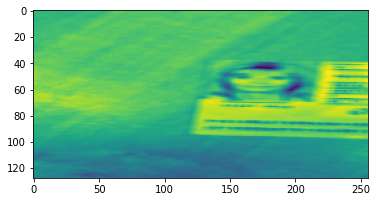

1700 ) Loss= 0.048417404


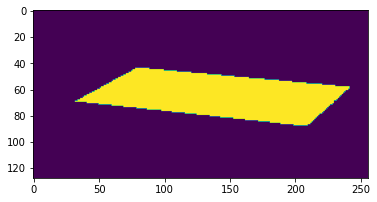

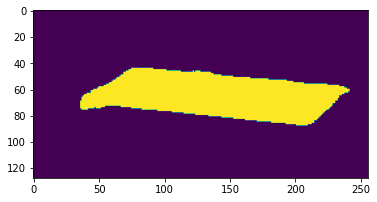

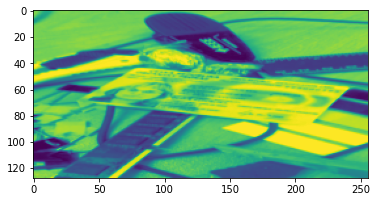

1800 ) Loss= 0.037353333


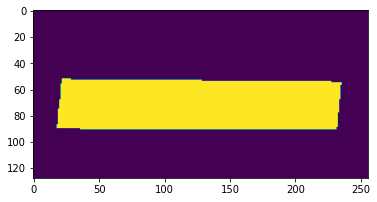

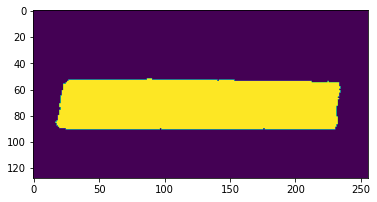

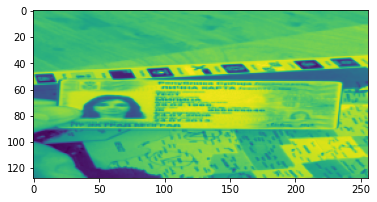

1900 ) Loss= 0.057074748


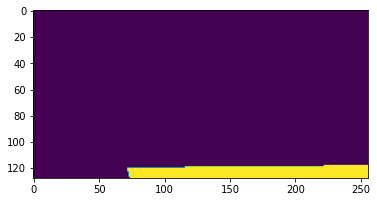

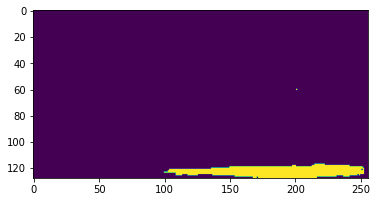

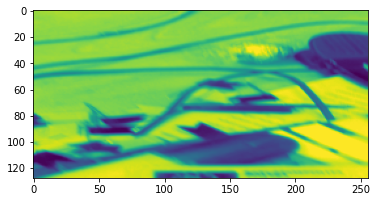

KeyboardInterrupt: 

In [5]:
#----------------Train--------------------------------------------------------------------------
m = torch.nn.Sigmoid()

for itr in range(10000): # Training loop
    images,ann=LoadBatch( train_split ) # Load taining batch
    images = images.to(device)

    ann = torch.autograd.Variable(ann, requires_grad=False).to(device) # Load annotation
    Pred=Net(images) # make prediction
    Net.zero_grad()

    Loss=loss_f(Pred, ann.long()) # Calculate cross entropy loss

    Loss.backward() # Backpropogate loss
    optimizer.step() # Apply gradient descent change to weight
    seg = torch.argmax(Pred[0], 0).cpu().detach().numpy()  # Get  prediction classes
    
    
    if itr % 1000 == 0: #Save model weight once every 60k steps permenant file
        print("Saving Model" +str(itr) + ".torch")
        torch.save(Net.state_dict(),   str(itr) + ".torch")
    
    if itr % 100 == 0: 
        print(itr,") Loss=",Loss.data.cpu().numpy())
        plt.imshow(ann.detach().cpu().numpy()[0])
        plt.show()
        plt.imshow(m(Pred).detach().cpu().numpy()[0][0] > 0.5)
        plt.show()
        
        plt.imshow(images.detach().cpu().numpy()[0][0])
        plt.show()
        

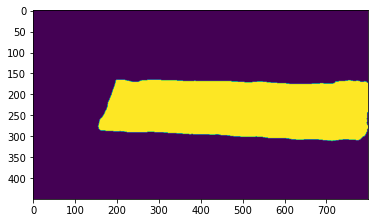

In [6]:
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
import matplotlib.pyplot as plt

modelPath = "9000.torch"  # Path to trained model

model = segmentation_models_pytorch.UnetPlusPlus(in_channels=3, classes=1)
model.load_state_dict(torch.load(modelPath))
model.to(device)

Img = test_split[0].image # load test image

width, height=256, 128 # image width and height
transformImg=tf.Compose([tf.Resize((height,width)),tf.ToTensor(),tf.Normalize( (0.485, 0.456, 0.406), 
                                                                               (0.229, 0.224, 0.225))])

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  # Check if there is GPU if not set trainning to CPU (very slow)

model.eval() # Set to evaluation mode
height_orgin , widh_orgin = Img.size # Get image original size 
d = 1

Img = transformImg(Img)  # Transform to pytorch
Img = torch.autograd.Variable(Img, requires_grad=False).to(device).unsqueeze(0)

with torch.no_grad():
    Prd = model(Img) # Run net

Prd = tf.Resize((height_orgin,widh_orgin))(Prd[0]) # Resize to origninal size
plt.imshow(Prd.detach().cpu().numpy()[0] > 0.5)  # display image
plt.show()
